# Process for separating FERENGI into red sequence and blue cloud

Based on data readily available, I'm using an NUV - r / r - J diagnostic to separate the FERENGI sample into red/passive and blue/active groups. u and r mags were available from SDSS, and NUV mags were from Galex. Finding matches for the galaxies in Galex was the most challenging step. J mags were from 2Mass. 

To obtain NUV mags:

I first used Vizier to find matches using the query_cat.py code in this repo. Using a max radius of 4" for matching positions (based on the Galex PSF of 4-6 arcsec), I could only find matches 41 out of the 71 FERENGI galaxies, which seemed quite low on the grounds that Schawinski et al. 2010 seemed to find Galex matches for most of GZ2. I still have not solved why this matching was so poor.

Instead I went to CasJobs, which has an old table which matches Galex objids with SDSS DR7 Ids. 57 FERENGI galaxies had at least one Galex match. http://galex.stsci.edu/GR6/?page=dbinfo&type=U
This usually found 1 Galex match to each SDSS ID, but occasionaly found 2-4 Galex matches. For galaxies with multiple matches, the NUV mags are extemely close. This code will show the difference in these values is negligible in the multiple matches, and extract one value for each. 

To obtain J mags:
I used Hugh's code here https://github.com/AstroZooMin/HughDickinsonMisc/blob/master/NewSloanFerengiCandidates/SloanNewFerengi.ipynb (in reality he sent me a table, but in the future I could use his code) to match the dr7 objids to the new dr12 ids. I then used casjobs via SDSS to match these to the 2Mass data they store in the TwoMass table. 50 of the 71 FERENGI galaxies had 2Mass J mag data.


In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.table import Table,Column,join
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import os
import scipy.stats.distributions as dist

from PIL import Image
import urllib, cStringIO
import random

#function for getting galaxy images
def get_image_from_url(url):

    file = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(file)
    return img


mpl.rcParams['text.usetex']=True
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20 


Populating the interactive namespace from numpy and matplotlib


In [3]:
#load the data - #94 galex matches for 71 FERENGI galaxies. groups are marked in the column 'Group ID'
data=Table.read('../data/galex_matches.fits')

In [4]:
#instead of masks - let 99 represent groups of 1
unmasked_ids = []
for row in data:
    if row['GroupID'] is ma.masked:
        unmasked_ids.append(99)
    else:
        unmasked_ids.append(row['GroupID'])

In [5]:
col = Column(unmasked_ids,name='GroupID_nomask')
data.add_columns([col])

In [6]:
IDs = set(data['GroupID_nomask'])

In [7]:
sdss_gals = set(data['sdss_id'])

In [121]:
#Table with NUV and J measurements for FERENGI galaxies
nuv_table = Table()  
c1 = Column(list(sdss_gals),name='sdss_id',dtype=int64)
c2 = Column(np.zeros(len(c1)),name = 'nuv_mag')
nuv_table.add_columns([c1,c2])


In [122]:
N_1 = 0 #number of galaxies with one galex match
nuv_dev = []
for i,gal in enumerate(sdss_gals):
    this_sdss_gal = (data['sdss_id']==gal)
    if len(data[this_sdss_gal])==1:
        N_1 += 1
        nuv_table.field('nuv_mag')[i]=data[this_sdss_gal]['nuv_mag']
    else: #galaxies with more than one galex match 
        nuvs = data[this_sdss_gal]['nuv_mag']
        nuv_dev.append(np.std(nuvs[nuvs>0]))
        nuv_table.field('nuv_mag')[i]=np.mean(nuvs[nuvs>0])


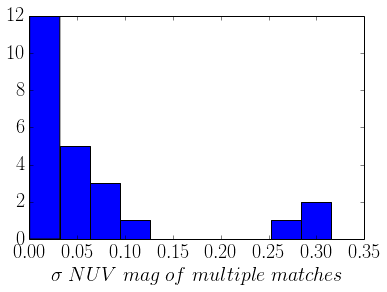

In [91]:
plt.hist(nuv_dev)
plt.xlabel('$\sigma~NUV~mag~of~multiple~matches$',fontsize=20)

## Above: for ferengis with multiple galex matches, the NUV mag measurements differ by less than 0.3 mags from the mean. Therefore, for these we will take the mean value. 

In [116]:
#join nuv_mags to ferengi data
fdata=Table.read('../data/ferengi_debiased.fits')

In [185]:
gf = join(fdata, nuv_table, keys='sdss_id',join_type='left')
gf.write('../data/ferengi_debiased_colors.fits')

## Later: J mags were obtained, added to ferengi_debiased_colors.fits

In [8]:
cdata=Table.read('../data/ferengi_debiased_nuv_J.fits')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


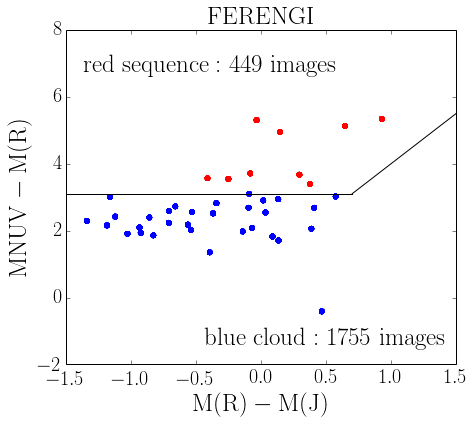

In [23]:
f=plt.figure(figsize=(7,6))

x1=np.linspace(-5,.7,100)
x2=np.linspace(.7,5,100)

red_sequence = (cdata['nuv_mag']-cdata['r']>3.1)
blue_cloud = (cdata['nuv_mag']-cdata['r']<3.1)
plt.plot(x1,3.1+0*x1,c='k')
plt.plot(x2,3*x2+1,c='k')

plt.scatter(cdata[red_sequence]['r']-cdata[red_sequence]['j'],cdata[red_sequence]['nuv_mag']-cdata[red_sequence]['r'],color='r')
plt.scatter(cdata[blue_cloud]['r']-cdata[blue_cloud]['j'],cdata[blue_cloud]['nuv_mag']-cdata[blue_cloud]['r'],color='b')

plt.xlim(-1.5,1.5)
plt.ylim(-2,8)
plt.ylabel('$\mathrm{MNUV-M(R)}$',fontsize=25)
plt.xlabel('$\mathrm{M(R)-M(J)}$',fontsize=25)
f.text(.16,.8,r'$\mathrm{red~sequence: %i~images}$'%len(cdata[red_sequence]),fontsize=25)
f.text(.4,.17,r'$\mathrm{blue~cloud: %i~images}$'%len(cdata[blue_cloud]),fontsize=25)
plt.title('$\mathrm{FERENGI}$',fontsize=25)


In [153]:
#m-M = distmod
#M = m - distmod
from astropy.cosmology import WMAP9 


(0, 1)

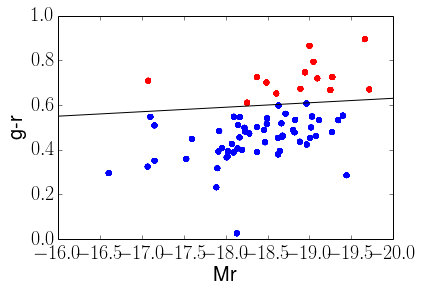

In [182]:
M = np.linspace(-20,-15,10)
plt.scatter(gf[red_sequence]['r']-WMAP9.distmod(gf[red_sequence]['redshift']).value,gf[red_sequence]['g']-gf[red_sequence]['r'],color='r')
plt.scatter(gf[blue_cloud]['r']-WMAP9.distmod(gf[blue_cloud]['redshift']).value,gf[blue_cloud]['g']-gf[blue_cloud]['r'],color='b')
plt.plot(M,.63-.02*(M+20),color='k')
plt.xlabel('Mr',fontsize=20)
plt.ylabel('g-r',fontsize=20)
plt.gca().invert_xaxis()
plt.xlim(-16,-20)
plt.ylim(0,1)


In [177]:
red_sequence = (gf['g']-gf['r'] > .63-.02*(gf['r']-WMAP9.distmod(gf['redshift']).value+20))
blue_cloud = (gf['g']-gf['r'] < .63-.02*(gf['r']-WMAP9.distmod(gf['redshift']).value+20))

699

In [184]:
len(gf[blue_cloud])

2750